In [94]:
import numpy as np
import hist
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
import warnings

In [75]:
# Global variables
# ----------------

x0, x1 = 1, 10  # Integration interval
fit_on = True
nruns = 108  #  all: 108

In [76]:
# Fit functions definitions
# -------------------------

def VWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return N*np.exp(-(x-mu)**2/(2*sig**2))

def PL(x, N, mu, a1, a2, a3):
    return N*(1+a1*x)/(a2*x+a3*x)
    #return N*(a1*x**2+a2*x+a3)  # test
    
def DE(x, N, a1, a2, a3):
    return N*(np.exp(a1*x) + a2*np.exp(a3*x))

def expVWG(x, N, mu, alpha, beta):
    X = (x-mu)/mu
    sig = alpha + beta*X
    return np.exp(N*np.exp(-(x-mu)**2/(2*sig**2)))

def expinterp(x, y1, y2, y3, y4):
    xi = np.linspace(1, 5, 4)
    return np.exp(interp1d(xi, [y1, y2, y3, y4], kind='cubic', bounds_error=False, fill_value='extrapolate')(x))

def CB2(x, N, mu, sig, alphaL, nL, alphaR, nR):
    if (type(x) is float):
        x = np.array([x])
    AL = ( nL / np.absolute( alphaL ) )**nL * np.exp( -1 * np.absolute( alphaL )**2 / 2 )
    AR = ( nR / np.absolute( alphaR ) )**nR * np.exp( -1 * np.absolute( alphaR )**2 / 2 )
    BL = nL / np.absolute( alphaL ) - np.absolute( alphaL )
    BR = nR / np.absolute( alphaR ) - np.absolute( alphaR )

    result = np.zeros(np.shape(x))
    
    rel = ( x - mu )/sig
    I1 = rel < -1 * alphaL
    I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
    I3 = rel > alphaR
    result[I1] = AL * (BL - rel[I1])**(-nL)
    result[I2] = np.exp(-1 * rel[I2]**2 / 2)
    result[I3] = AR*(BR + rel[I3])**(-nR)
        
    return result * N #/ (np.sqrt(2 * np.pi) * sig)

def sig2CB2(cov,  x, N, mu, sig, alphaL, nL, alphaR, nR):
    # CB2 Derivatives
    def CB2intervals(rel, alphaL, alphaR):
        I1 = rel < -1 * alphaL
        I2 = (rel >= -1 * alphaL) * (rel <= alphaR)
        I3 = rel > alphaR
        return I1, I2, I3

    def dCB2dN(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = ((nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)[I1]
        res[I2] = (np.exp(-(-mu + x)**2/(2*sig**2)))                                                                             [I2]
        res[I3] = ((nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR)[I3]
        return res

    def dCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*np.exp(-np.abs(alphaL)**2/2)/(sig*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
        res[I2] = (-N*(2*mu - 2*x)*np.exp(-(-mu + x)**2/(2*sig**2))/(2*sig**2)                                                                                                                   ) [I2]
        res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*np.exp(-np.abs(alphaR)**2/2)/(sig*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
        return res

    def dCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR):
        if (type(x) is float):
            x = np.array([x])
        rel = (x-mu)/sig
        I1, I2, I3 = intervals(rel, alphaL, alphaR)
        res = np.zeros(np.shape(x))
        res[I1] = (-N*nL*(nL/np.abs(alphaL))**nL*(-mu + x)*np.exp(-np.abs(alphaL)**2/2)/(sig**2*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)*(nL/np.abs(alphaL) - np.abs(alphaL) - (-mu + x)/sig)**nL)) [I1]
        res[I2] = (N*(-mu + x)**2*np.exp(-(-mu + x)**2/(2*sig**2))/sig**3                                                                                                                                     ) [I2]
        res[I3] = (N*nR*(nR/np.abs(alphaR))**nR*(-mu + x)*np.exp(-np.abs(alphaR)**2/2)/(sig**2*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)*(nR/np.abs(alphaR) - np.abs(alphaR) + (-mu + x)/sig)**nR) ) [I3]
        return res
    
    def IdCB2dN(x, *args):
        return quad(dcbdN, x0, x1, args=args)[0]

    def IdCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR):
        return quad(dcbdmu, x0, x1, args=args)[0]

    def IdCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR):
        return quad(dcbdsig, x0, x1, args=args)[0]
    
    return IdCB2dN(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[0,0]
    +IdCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[1,1]
    +IdCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR)**2 * cov[2,2]
    +2*IdCB2dN(x, N, mu, sig, alphaL, nL, alphaR, nR)*IdCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[0, 1])
    +2*IdCB2dN(x, N, mu, sig, alphaL, nL, alphaR, nR)*IdCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[0, 2])
    +2*IdCB2dmu(x, N, mu, sig, alphaL, nL, alphaR, nR)*IdCB2dsig(x, N, mu, sig, alphaL, nL, alphaR, nR) * np.sqrt(cov[1, 2])
    

def datamodel(resofunc, bgfunc):
    def f(x, *args):
        return resofunc(x, *args[:7]) + resofunc(x, *args[7:14]) + bgfunc(x, *args[14:])
    return f
    
def sig2(func):
    if func is CB2:
        f = sig2CB2
    return f

# test
#x = np.arange(2,4,0.01)
#p = [1, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038]
#y =  dcbdsig(x, *p) 
#plt.plot(x,y)
#IdcbdN(x,*p)

In [80]:
def gethistdata(h,xmin,xmax):
    ''' Get data from histo '''
    y,x = h[xmin*1j:xmax*1j].to_numpy()
    x = x[:-1]+(x[1]-x[0])/2  # set x to middles instead of lower bound of bins
    return x,y

def fillhist(h,type,pTl,pTu):
    f = open(f'mass/{type}.pT{pTl}-{pTu}.npy', 'rb')
    for i in range(nruns):
        A = np.load(f)
        #print(A)
        h.fill(A)
    f.close()

# Make bounds
def mklb(p0, var):
    return p0*(1-np.sign(p0)*var)

def mkub(p0, var):
    return p0*(1+np.sign(p0)*var)

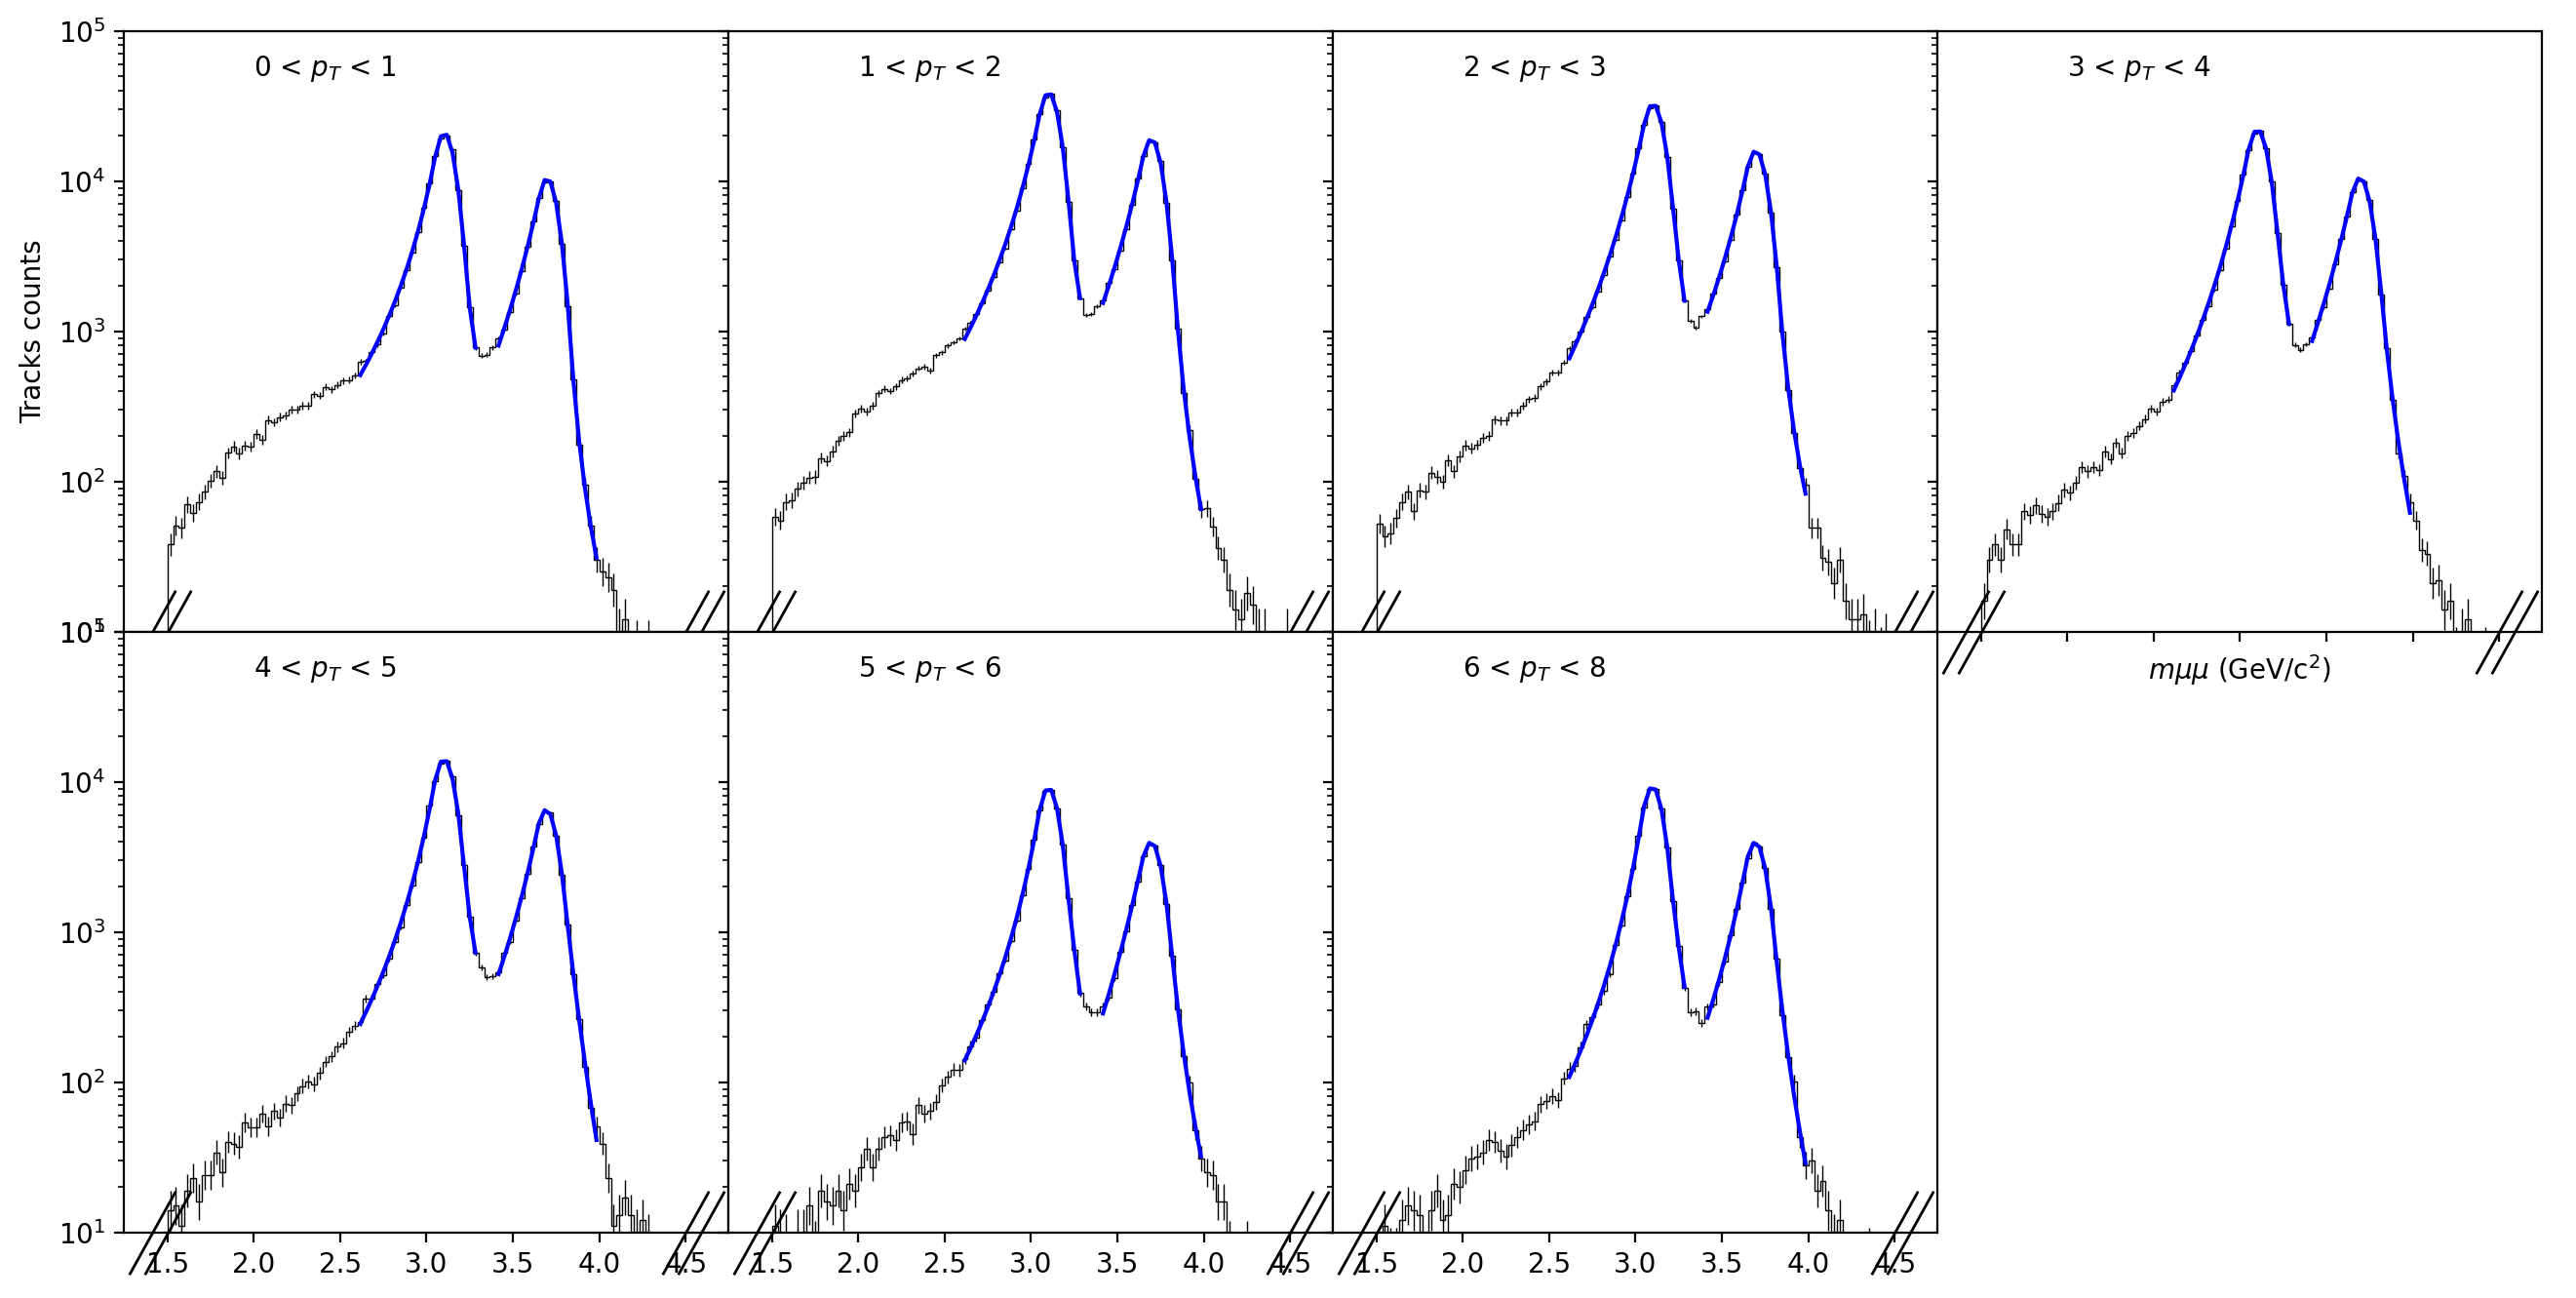

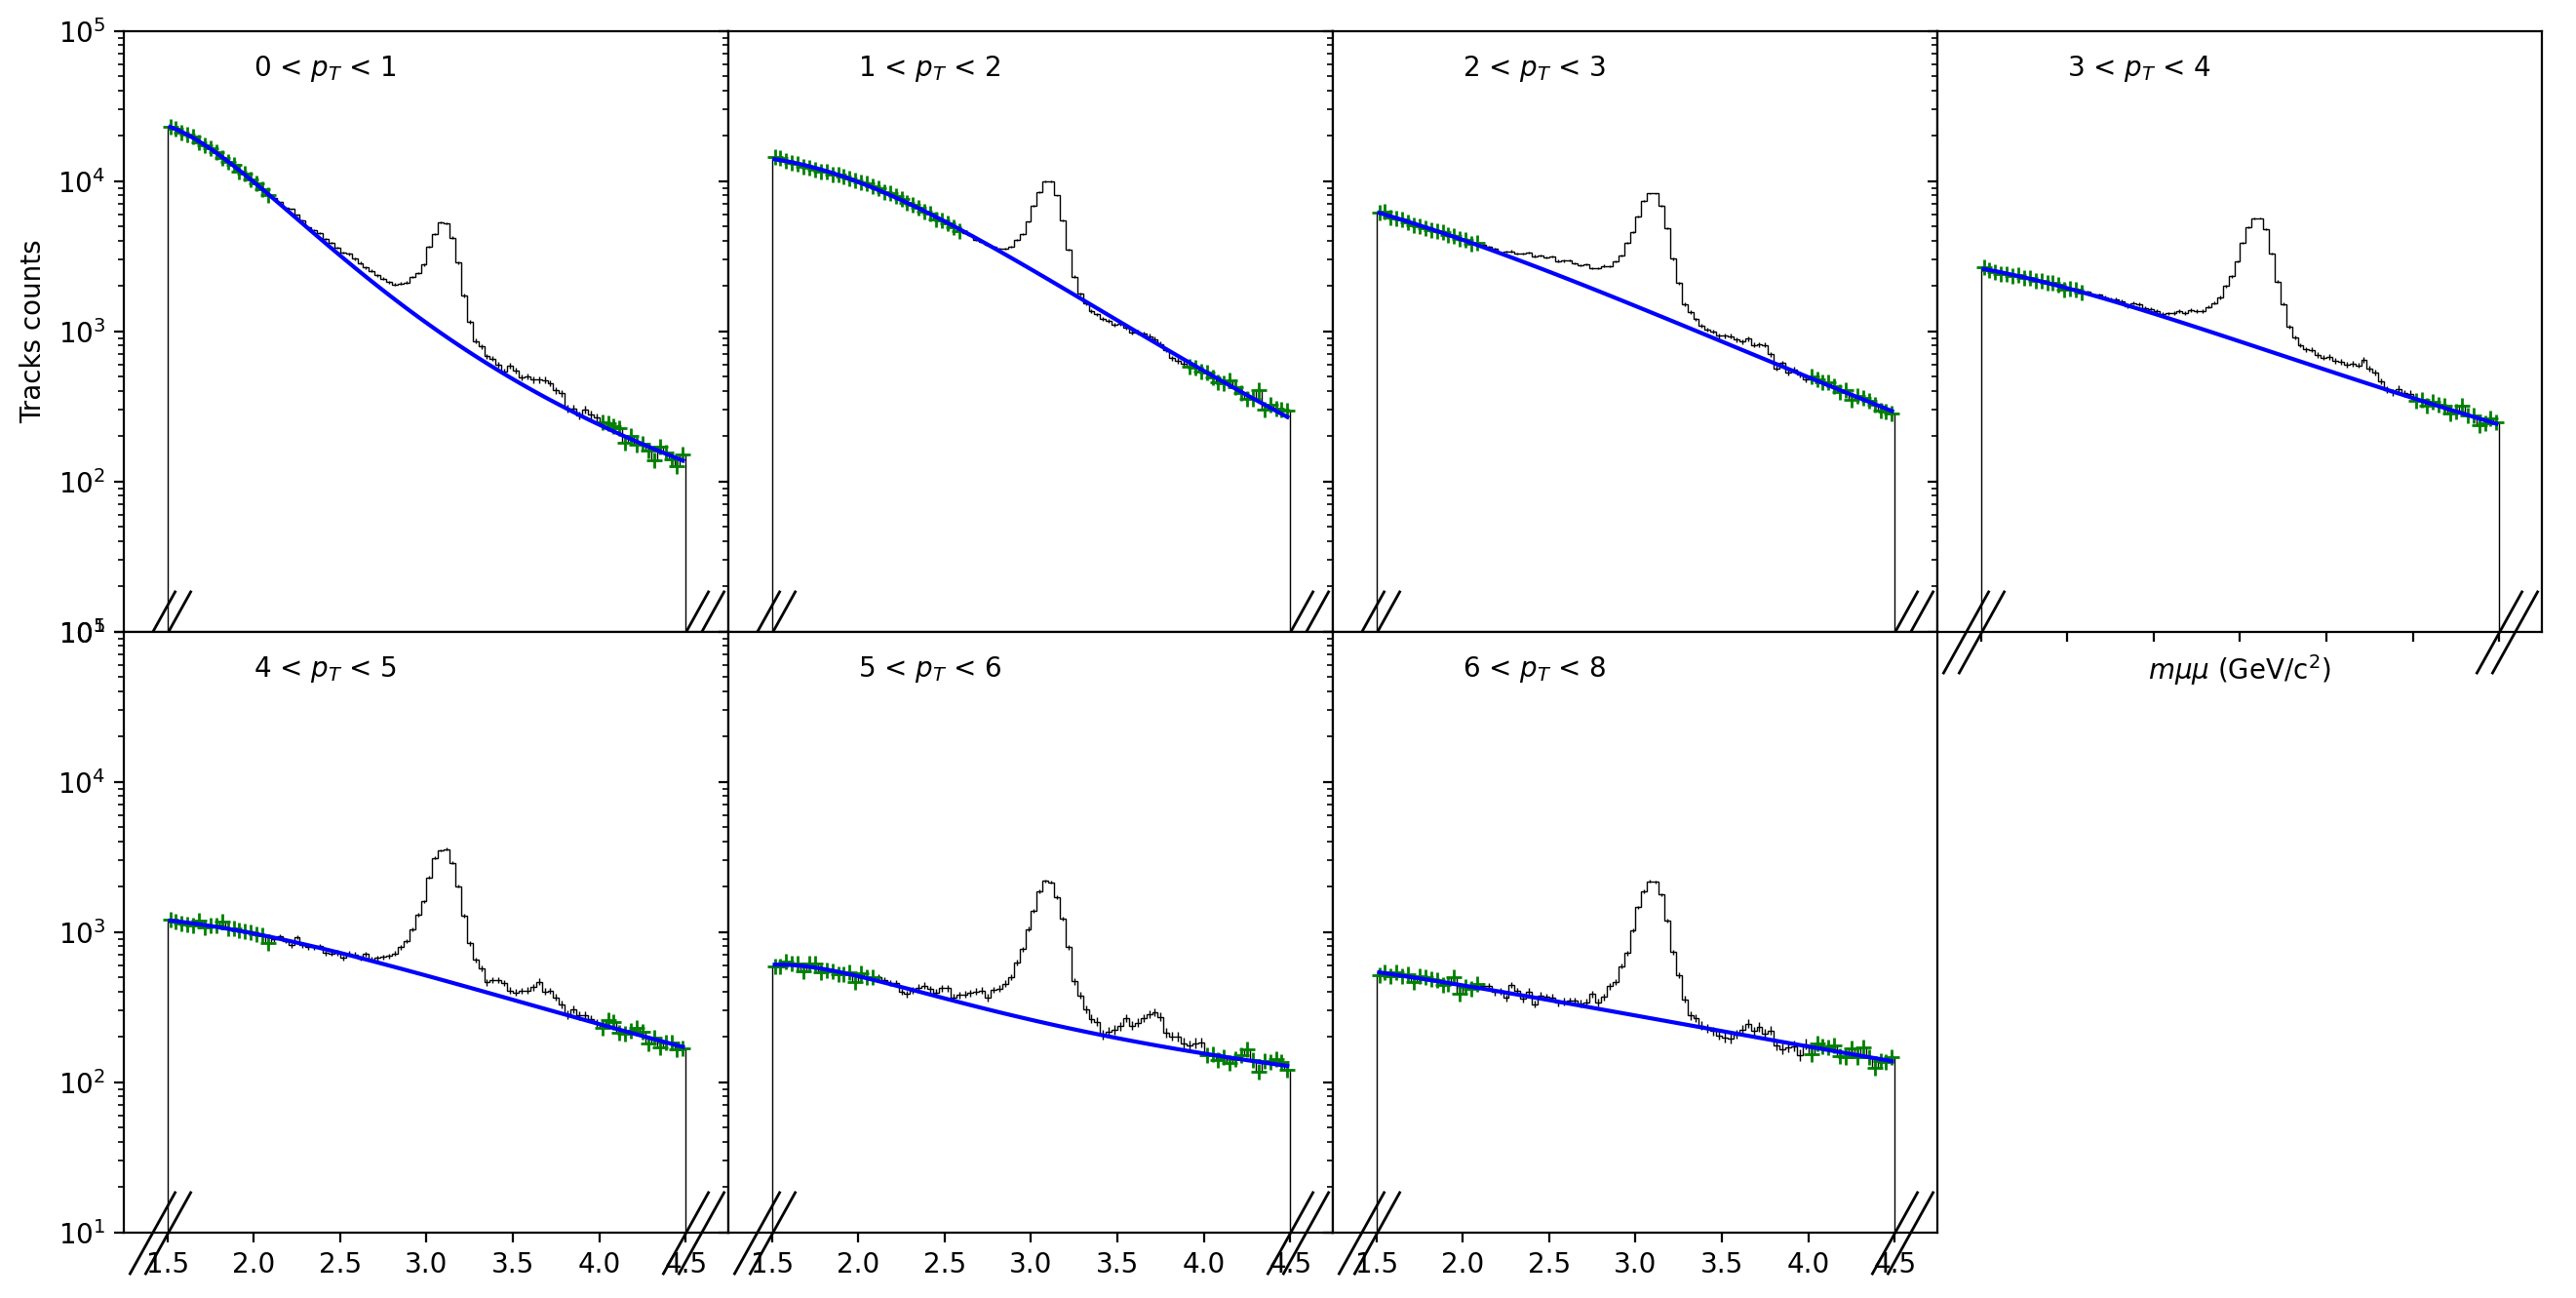

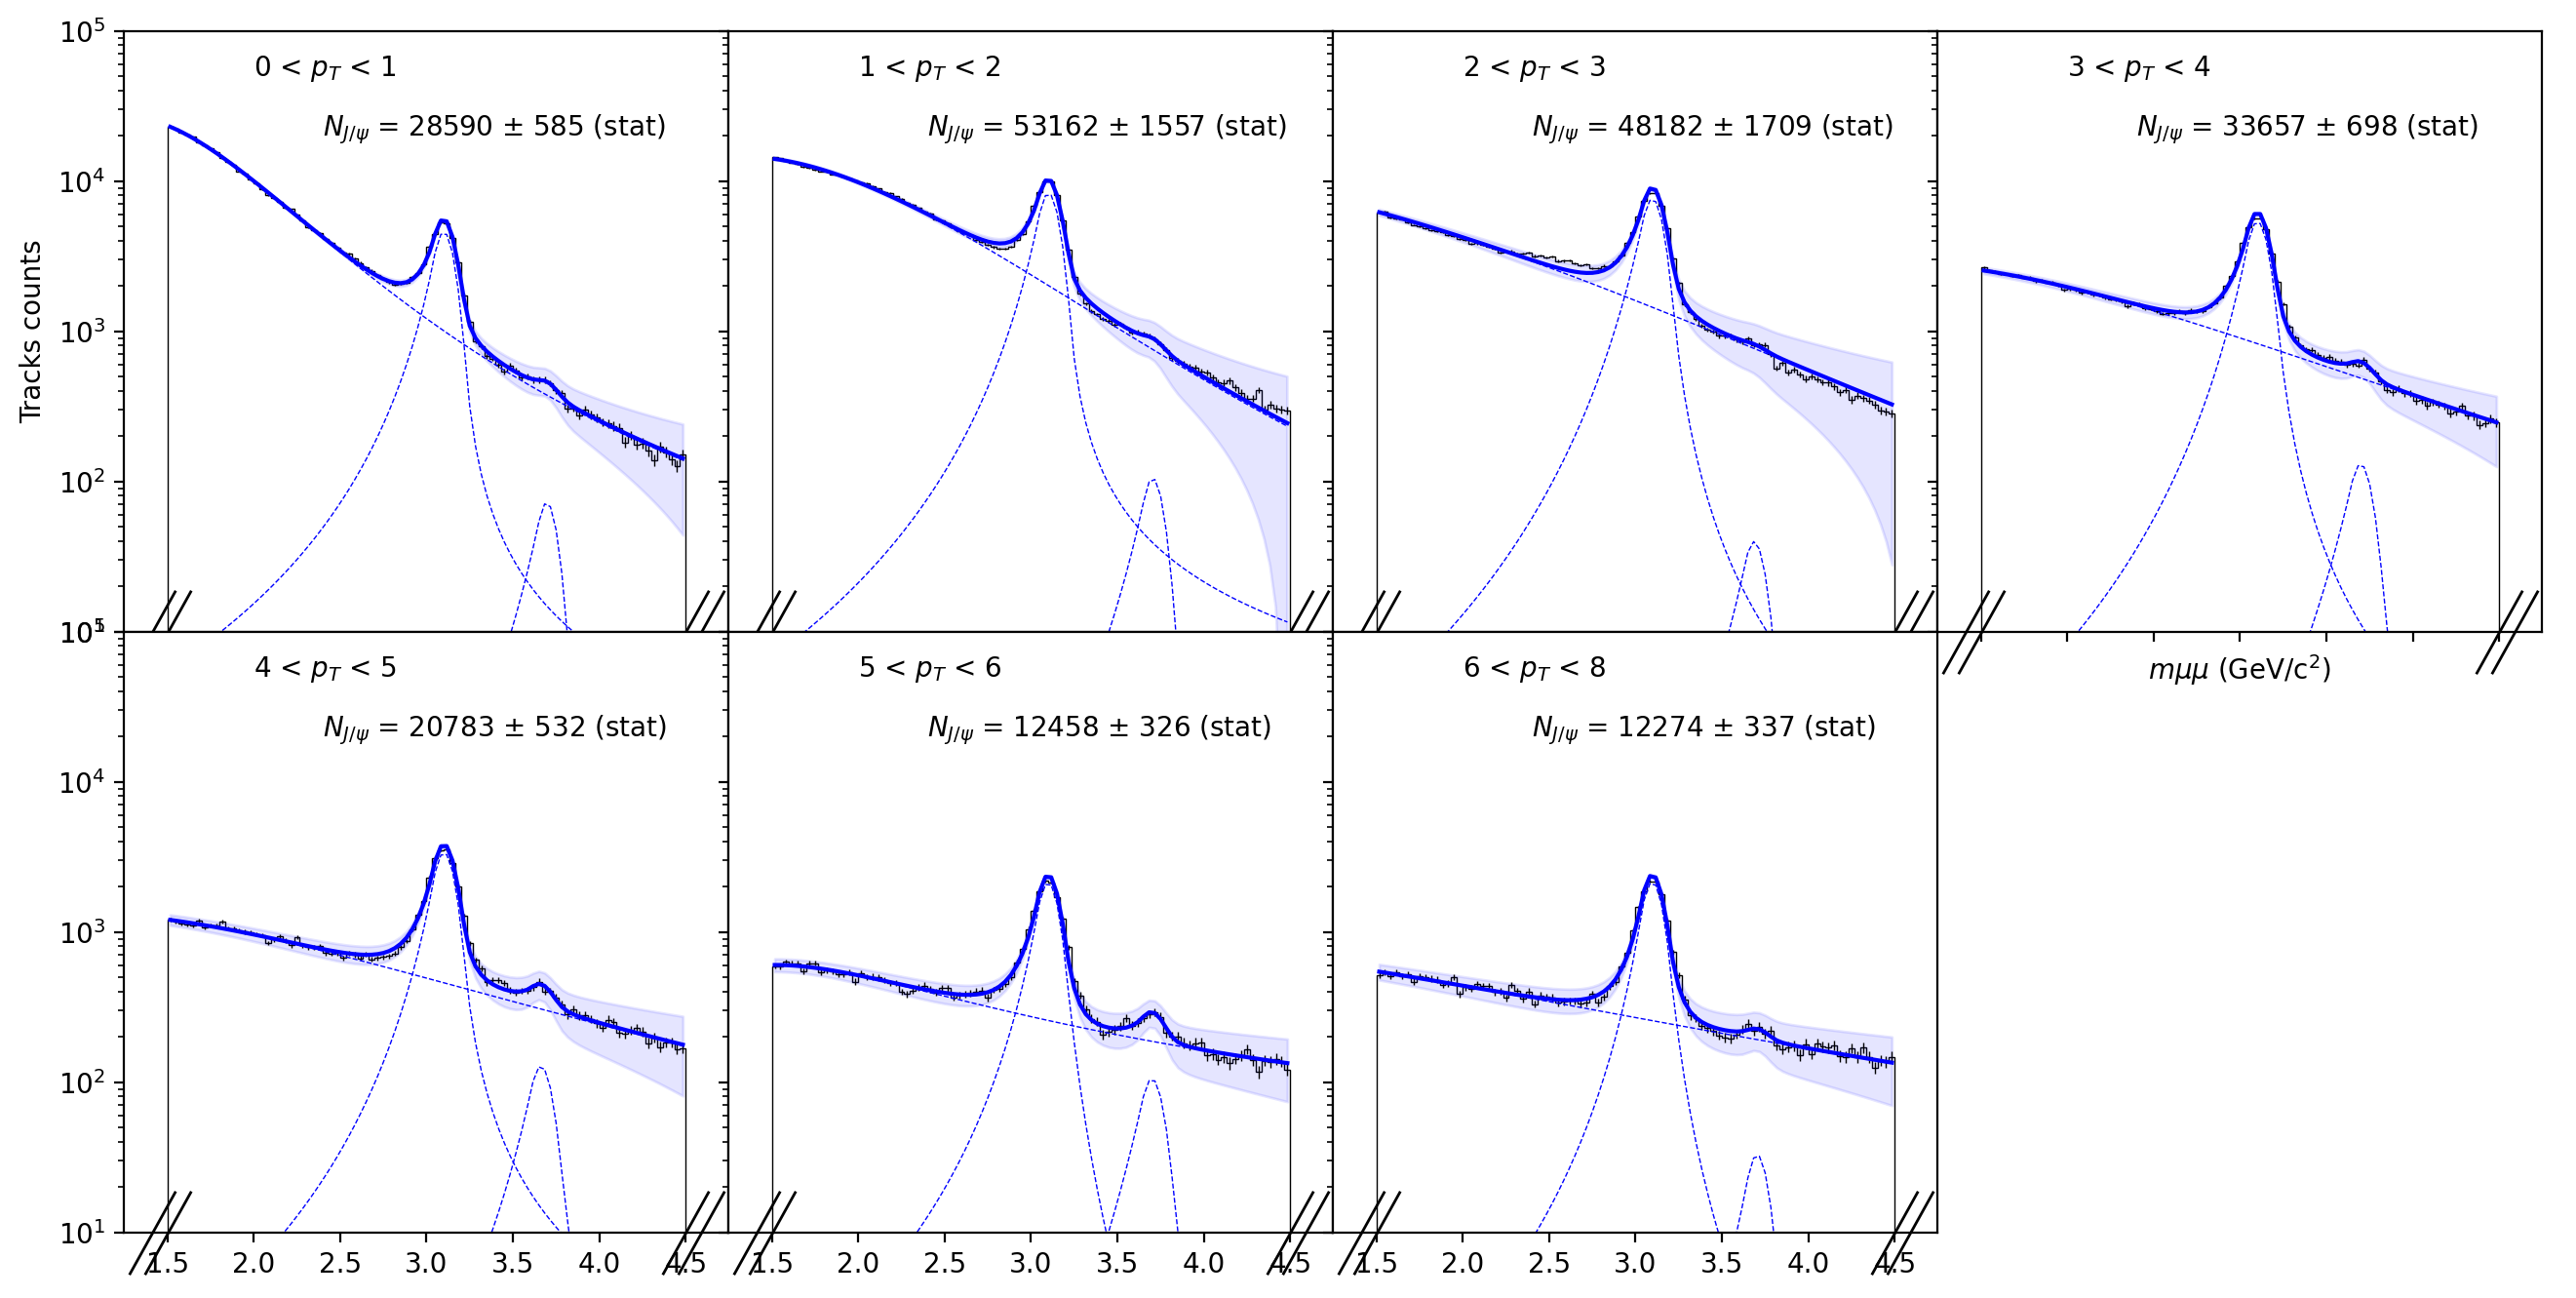

In [109]:
#  pT differential analysis
#  ------------------------

warnings.filterwarnings('ignore')
    
def setaxes(ax):
    ax.set_ylim(1e1,1e5)
    ax.set_yscale("log")
    ax.text(2, 5e4, f"{pTl} < $p_T$ < {pTu}")
    ax.set_xlabel('')
    if i==3: ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
    if i==0: ax.set_ylabel("Tracks counts")



resofunc = CB2
bgfunc = expVWG

nbin = 90
massmin = 1.5
massmax = 4.5
dmass = (massmax-massmin)/nbin


fig = []
axs = []
for i in range(3):
    fig.append(plt.figure(i+1, dpi=200, figsize=(16,8)))
    gs = fig[i].add_gridspec(2, 4, hspace=0, wspace=0)
    axs.append(gs.subplots(sharex='col', sharey='row'))
    axs[i][1,-1].remove()
    

IJPsi_pT = []


pTcuts = [0,1,2,3,4,5,6,8]
for i in range(len(pTcuts)-1):
    pTl = pTcuts[i]
    pTu = pTcuts[i+1]

    # Fill histograms
    hmc =   hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    fillhist(hmc,'mc',pTl,pTu)
    fillhist(hdata,'data',pTl,pTu)
    
    mass,Nmc = gethistdata(hmc,massmin,massmax)
    mass,Ndata = gethistdata(hdata,massmin,massmax)
    
    
    ##########################
    #  MC Crystal Balls fit  #
    ##########################
    
    if 1:
        ax = axs[0].flatten()[i]
        hmc.plot(ax=ax, label="Selected events", color='black', ls='-', lw=0.5);
        setaxes(ax)
        
        # Intervals for fit
        Dnul = Nmc==0
        DJPsi = (2.6<mass)*(mass<3.3) * ~Dnul
        DPsi2S = (3.4<mass)*(mass<4.0) * ~Dnul


        # p0

        p0JPsi = np.array([(hmc[3.10*1j]), 3.10, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        p0Psi2S = np.array([(hmc[3.68*1j]), 3.68, 7.29e-02, 9.96e-01, 3.04e+00, 1.82e+00, 2.55e+01])
        #ax.plot(mass[DJPsi],(crystalball(mass,*p0JPsi))[DJPsi],':r', alpha=0.5,label="")
        #ax.plot(mass[DPsi2S],(crystalball(mass,*p0Psi2S))[DPsi2S],':r', alpha=0.5,label="")
        #print('p0 J/psi:', p0JPsi)
        #print('p0 psi(2S):', p0Psi2S)
        
 
        # Fit JPsi and Psi2S independently
        if fit_on:
            try:
                pfitJPsi, _ = curve_fit(resofunc, mass[DJPsi], Nmc[DJPsi], sigma=np.sqrt(Nmc[DJPsi]), p0=[*p0JPsi], method='trf')
                pfitPsi2S, _ = curve_fit(resofunc, mass[DPsi2S], (Nmc[DPsi2S]), sigma=np.sqrt(Nmc[DPsi2S]), p0=[*p0Psi2S], method='trf')

                ax.plot(mass[DJPsi], (resofunc(mass,*pfitJPsi))[DJPsi], 'b')
                ax.plot(mass[DPsi2S], (resofunc(mass,*pfitPsi2S))[DPsi2S], 'b')
            except Exception as e:
                #raise(e)
                pass

        # Charlig p0 (tails)
        p0JPsi[:] = [40248.03611688854, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038]
       
    
    #########################
    #  Data background fit  #
    #########################
    
    if 1:
        # Remove JPsi and Psi2S intervals from data in order to fit the background only
        if i==1:
            Dbg = ~((2.6<mass)*(mass<3.9))
        else:    
            Dbg = ~((2.1<mass)*(mass<4.0))
        
        ax = axs[1].flatten()[i]
        hdata.plot(ax=ax, color='black',ls='-',lw=0.5)
        ax.plot(mass[Dbg],Ndata[Dbg],'+g')
        setaxes(ax)

        #p0 = [1e3, -1, 1e2, -3]
        #bounds = ([0, -10, 0, -10],[1e5, 0, 1e4, 0])
        #ax.plot(mass,(DE(mass,*p0)))
        
        # Fit bg
        if fit_on:
            try:
                pfitbg, covbg = curve_fit(bgfunc, mass[Dbg], (Ndata[Dbg]), sigma=np.sqrt(Ndata[Dbg]), method='trf')
                ax.plot(mass,(bgfunc(mass,*pfitbg)),'b')
            except Exception as e:
                #raise(e)
                pass

    ###############
    #  Final fit  #
    ###############
    
    if 1:
        ax = axs[2].flatten()[i]
        hdata.plot(ax=ax,label="Selected events",color='black',ls='-',lw=0.5)
        setaxes(ax)
        
        if fit_on:
            # bounds
            varbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
            varreso = np.array([10, 0.02, 0.02, *0.001*np.ones(4)])  # peaks parameters variation factor around p0
            lb = np.array([*mklb(pfitJPsi,varreso), *mklb(pfitPsi2S,varreso), *mklb(pfitbg,varbg)])
            ub = np.array([*mkub(pfitJPsi,varreso), *mkub(pfitPsi2S,varreso), *mkub(pfitbg,varbg)])
            bounds = (lb,ub)
            
            # Set p0 peaks amplitudesfrom data
            pfitJPsi[0] = (hdata[pfitJPsi[1]*1j])
            pfitPsi2S[0] = (hdata[pfitPsi2S[0]*1j])
            
            try:
                pfit, cov = curve_fit(
                    datamodel(resofunc, bgfunc), mass, (Ndata),
                    sigma=np.sqrt(Ndata),
                    p0=[*pfitJPsi, *pfitPsi2S, *pfitbg],
                    bounds=bounds,
                    method='trf')                
                #print(pfit)

                Nfit = datamodel(resofunc, bgfunc)(mass,*pfit)
                NJPsi = resofunc(mass,*pfit[:7])
                NPsi2S = resofunc(mass,*pfit[7:14])
                ax.plot(mass, Nfit,'b')
                ax.plot(mass, NJPsi,'--b',lw=0.5)
                ax.plot(mass, NPsi2S,'--b',lw=0.5)
                ax.plot(mass,(bgfunc(mass,*pfit[14:])),'--b',lw=0.5)
                
                #print(cov/abs(pfit))
                # Fit error
                cov[3:7] = 0
                cov[10:14] = 0
                errfit = np.sqrt(np.sum(np.diag(cov)))

                ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 
                
                # J/psi Integral
                IJPsi = quad(resofunc, x0, x1, args=tuple(pfit[:7]))[0]

                # J/psi Integral error
                errJPsi = np.sqrt(sig2(resofunc)(cov[:7,:7], mass, *pfit[:7]))
                ax.text(2.4, 2e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errJPsi/dmass:.0f} (stat)')
                #print(IJPsi/dmass)
                #print(errJPsi/dmass)
            except Exception as e:
                raise(e)
                pass
            
            
fig[0].savefig('fig/MC_fit.pdf')
fig[1].savefig('fig/bg_fit.pdf')
fig[2].savefig('fig/final_fit.pdf')

In [106]:
#  All pT final plot
#  -----------------

    
def finalfit(nbin, massmin, massmax, bgfunc=expVWG, resofunc=CB2, plot_on=False):
    dmass = (massmax-massmin)/nbin
    
    # Fill histograms
    #hmc = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))
    hdata = hist.Hist(hist.axis.Regular(bins=nbin,start=massmin,stop=massmax))


    #fillhist(hmc, 'mc')
    fillhist(hdata, 'data', 0, 1000)

    mass, Ndata = gethistdata(hdata,massmin,massmax)

    if plot_on:
        fig = plt.figure()
        ax = plt.gca()
        hdata.plot(label="Selected MC events",color='black',ls='-',lw=0.5)

    #########################
    #  Data background fit  #
    #########################

    if 1:
        # Remove JPsi and Psi2S intervals from data in order to fit the background only
        Dbg = ~((2.3<mass)*(mass<4.0))

        # Fit bg
        try:
            pfitbg, covbg = curve_fit(bgfunc, mass[Dbg], (Ndata[Dbg]),
                                      sigma=np.sqrt(Ndata[Dbg]),
                                      bounds=(np.zeros(4), np.inf*np.ones(4)),
                                      method='trf')

        except Exception as e:
            raise(e)
            pass

    if 1:
        #p0JPsi = [40248, 3.09982601e+00, 6.29620649e-02, 8.56477234e-01, 3.11309364e+00, 2.05460074e+00, 1.50361309e+00]
        p0JPsi = [40248.03611688854, 3.1043969164973095, 0.05916830498610536, 0.9498690813388607, 3.026452516177861, 2.3298518901185084, 4.293297264238038] # Charlig
        p0Psi2S = [3e3, 3.69660321e+00, 5.93585320e-02, 7.45529120e-01, 4.99564973e+00, 2.30142894e+00, 3.08316961e+00]

        # bounds
        varbg = np.ones(np.shape(pfitbg))*0.1 # bg parameters variation factor around p0
        varpks = np.array([10, 0.1, 0.1, *0.01*np.ones(4)])  # peaks parameters variation factor around p0
        lb = np.array([*mklb(p0JPsi,varpks), *mklb(p0Psi2S,varpks), *mklb(pfitbg,varbg)])
        ub = np.array([*mkub(p0JPsi,varpks), *mkub(p0Psi2S,varpks), *mkub(pfitbg,varbg)])
        bounds = (lb,ub)

        # Set p0 peaks amplitudesfrom data
        #p0JPsi[0] = (hdata[p0JPsi[1]*1j])
        #p0Psi2S[0] = (hdata[p0Psi2S[0]*1j])

        try:
            pfit, cov = curve_fit(
                datamodel(resofunc, bgfunc), mass, (Ndata),
                sigma=np.sqrt(Ndata),
                p0=[*p0JPsi, *p0Psi2S, *pfitbg],
                bounds=bounds,
                method='trf')

            Nfit = datamodel(resofunc, bgfunc)(mass,*pfit)
            NJPsi = resofunc(mass,*pfit[:7])
            NPsi2S = resofunc(mass,*pfit[7:14])
            Nbg = bgfunc(mass,*pfit[14:])
            if plot_on:
                ax.plot(mass, Nfit,'b')
                ax.plot(mass, NJPsi,'--b',lw=0.5)
                ax.plot(mass, NPsi2S,'--b',lw=0.5)
                ax.plot(mass, Nbg,'--b',lw=0.5)

            #print(cov/abs(pfit))
            # Fit error
            cov[3:7] = 0
            cov[10:14] = 0
            errfit = np.sqrt(np.sum((np.diag(cov))))

            if plot_on: ax.fill_between(mass, Nfit-errfit, Nfit+errfit, color='blue', alpha=0.1) 

            # J/psi Integral
            IJPsi = quad(resofunc, x0, x1, args=tuple(pfit[:7]))[0]

            # J/psi Integral error
            errJPsi = np.sqrt(sig2(resofunc)(cov[:7,:7], mass, *pfit[:7]))
            if plot_on: ax.text(3.3, 5e4, f'$N_{{J/\psi}}$ = {IJPsi/dmass:.0f} $\pm$ {errJPsi/dmass:.0f} (stat)')
            #print(IJPsi/dmass)
            #print(errJPsi/dmass)

        except Exception as e:
            raise(e)
            pass
    
    if plot_on:
        ax.set_ylim(1e2,1e5)
        ax.set_yscale("log")
        #ax.text(2, 5e4, f"")
        ax.set_xlabel('$m\mu\mu$ (GeV/c$^2$)')
        ax.set_ylabel("Tracks counts")

        fig.savefig('fig/all_pT_final_fit.pdf')

        #fig2 = plt.figure(3)
        #hdata.plot(label="Selected data events",color='black',ls='-',lw=0.5)
    
    return IJPsi/dmass, errJPsi/dmass


(208285.8978677392, 2920.9551546606535)

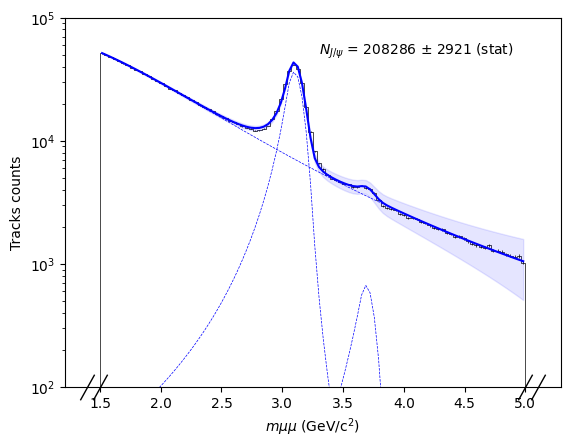

In [107]:
finalfit(100, 1.5, 5.0, bgfunc=expVWG, plot_on=True)

Text(0, 0.5, '$N_{J/\\psi}$')

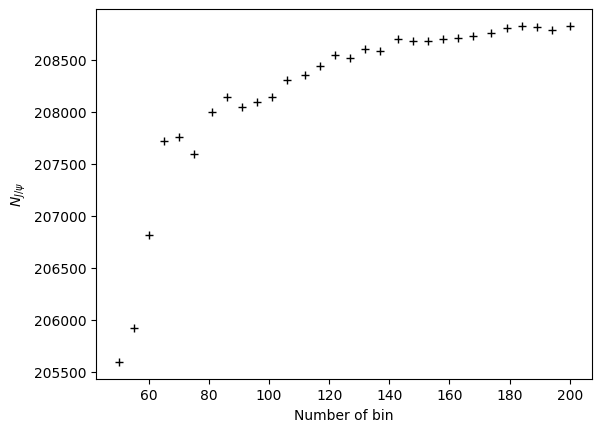

In [99]:
#  nbin systematic analysis
#  ------------------------

nbins = np.linspace(50,200,30, dtype=np.int16)
NJPsi_nbin = []
errNJPsi_nbin = []
for nbin in nbins:
    NJPsi, errNJPsi = finalfit(nbin,1.5,5.0, plot_on=False)
    NJPsi_nbin.append(NJPsi)
    errNJPsi_nbin.append(errNJPsi)

plt.plot(nbins, NJPsi_nbin, "+k")
plt.xlabel('Number of bin')
plt.ylabel('$N_{J/\psi}$')

Text(0, 0.5, '$N_{J/\\psi}$')

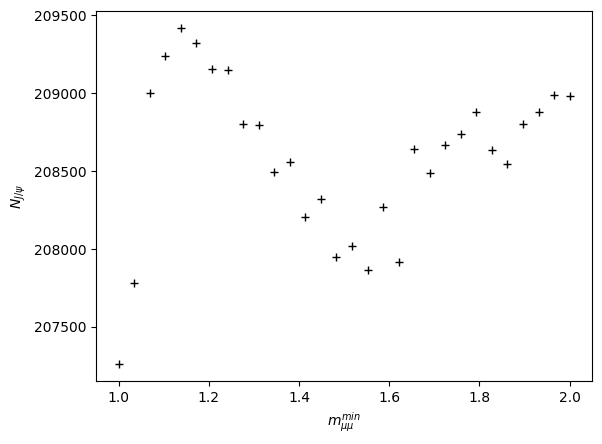

In [100]:
#  massmin systematic analysis
#  ---------------------------

massmins = np.linspace(1,2,30)
NJPsi_massmin = []
errNJPsi_massmin = []
for massmin in massmins:
    NJPsi, errNJPsi = finalfit(90, massmin, 4.5, plot_on=False)
    NJPsi_massmin.append(NJPsi)
    errNJPsi_massmin.append(errNJPsi)

plt.plot(massmins, NJPsi_massmin, "+k")
plt.xlabel('$m_{\mu\mu}^{min}$')
plt.ylabel('$N_{J/\psi}$')

In [101]:
#  Background function systematic analysis
#  ---------------------------------------
print(finalfit(90, 1.5, 5, bgfunc=expVWG))
print(finalfit(90, 1.5, 5, bgfunc=expinterp))

(208332.60701506527, 3206.512379666447)
(206300.11707111503, 3262.034972817611)
